# Ensemble Model

Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler

from collections import Counter

pd.pandas.set_option('display.max_columns', None)

In [2]:
crash_19 = pd.read_csv('crash_19')

Setting column 'RD_NO' as index.

In [3]:
crash_19.set_index(['RD_NO'], inplace = True)

In [4]:
crash_19.head()

,POSTED_SPEED_LIMIT,STREET_NO,NUM_UNITS,MOST_SEVERE_INJURY,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,DEVICE_CONDITION_FUNCTIONING IMPROPERLY,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_OTHER,DEVICE_CONDITION_UNKNOWN,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL,LIGHTING_CONDITION_DARKNESS,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,FIRST_CRASH_TYPE_ANGLE,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,TRAFFICWAY_TYPE_ALLEY,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED),TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN BARRIER,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_NOT REPORTED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_UNKNOWN,TRAFFICWAY_TYPE_UNKNOWN INTERSECTION TYPE,TRAFFICWAY_TYPE_Y-INTERSECTION,ALIGNMENT_CURVE ON GRADE,ALIGNMENT_CURVE ON HILLCREST,"ALIGNMENT_CURVE, LEVEL",ALIGNMENT_STRAIGHT AND LEVEL,ALIGNMENT_STRAIGHT ON GRADE,ALIGNMENT_STRAIGHT ON HILLCREST,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER,"ROADWAY_SURFACE_COND_SAND, MUD, DIRT",ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_UNKNOWN,ROAD_DEFECT_WORN SURFACE,PRIM_CONTRIBUTORY_CAUSE_ANIMAL,PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE,"PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY,PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION,"PRIM_CONTRIBUTORY_CAUSE_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT,PRIM_CONTRIBUTORY_CAUSE_EXCEEDING SAFE SPEED FOR CONDITIONS,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_NOT APPLICABLE,PRIM_CONTRIBUTORY_CAUSE_OBSTRUCTED CROSSWALKS,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,PRIM_C

In [5]:
crash_19.shape

(117427, 119)

In [6]:
crash_19['MOST_SEVERE_INJURY'].value_counts()

0    106127
1     11300
Name: MOST_SEVERE_INJURY, dtype: int64

### Preprocessing

In [7]:
X = crash_19.drop(columns = 'MOST_SEVERE_INJURY')
y = crash_19['MOST_SEVERE_INJURY']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### VotingClassifier

In [ ]:
vote = VotingClassifier(
    # list of tuples ("alias", model object)
    [
    ('tree', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
    ], 
    voting = "soft")
vote_params = {
    'ada__n_estimators': [50,75],
    'ada__learning_rate': [.9, 1.],
    
    'gb__n_estimators': [100,125],
    'gb__max_depth': [2,3],
    'gb__learning_rate': [.9, 1.],
    
    'tree__max_depth': [None, 5]
}
gs = GridSearchCV(vote, param_grid=vote_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

### DecisionTree Classification Model

In [9]:
y.value_counts(normalize=True)

0    0.90377
1    0.09623
Name: MOST_SEVERE_INJURY, dtype: float64

In [34]:
tree = DecisionTreeClassifier(random_state = 42)

tree.fit(X_train, y_train)

ValueError: Invalid parameter tree for estimator DecisionTreeClassifier(random_state=42). Check the list of available parameters with `estimator.get_params().keys()`.

In [12]:
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, 0.8590114793745955)

In [13]:
preds = tree.predict(X_test)

In [22]:
def evaluation(y_actual, predicted):
    cnf_matrix = confusion_matrix(y_actual, predicted)

    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'viridis', fmt = 'd')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    labels = ['No Injury', 'Injury']
    print(classification_report(y_actual, predicted, target_names = labels))

              precision    recall  f1-score   support

   No Injury       0.93      0.92      0.92     26532
      Injury       0.29      0.32      0.31      2825

    accuracy                           0.86     29357
   macro avg       0.61      0.62      0.61     29357
weighted avg       0.87      0.86      0.86     29357



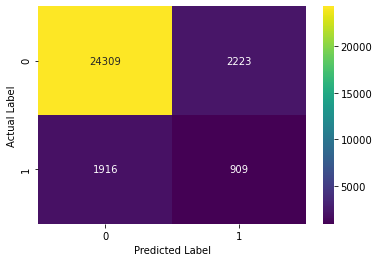

In [23]:
evaluation(y_test, preds)

### GradientBoosting Classifier

In [26]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv=3)
gb_gs.fit(X_train, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.9187691634523668


{'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 100}

In [36]:
gb_gs.score(X_train, y_train), gb_gs.score(X_test, y_test)

(0.9201771318269558, 0.918247777361447)

### Bagging Classification Model

In [16]:
# Instantiate dataframe.
predictions = pd.DataFrame(index=X_test.index)

# Generate ten decision trees.
for B in range(1, 11):
    
    # Bootstrap X data.
    # Should we add a random seed?
    X_sample = X_train.sample(n = X_train.shape[0],
                              replace=True)
    
    # Get y data that matches the X data.
    y_sample = y_train[X_sample.index]
    
    # Instantiate decision tree.
    t = DecisionTreeClassifier(random_state=42)
    
    # Fit to our sample data.
    t.fit(X_sample, y_sample)
    
    # Put predictions in dataframe.
    predictions[f'Tree {B}'] = t.predict(X_test)

predictions.head(20)

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
RD_NO,,,,,,,,,,
JC313119,0,0,0,0,0,0,0,0,0,0
JC165443,1,0,0,0,0,0,0,0,0,0
JC442756,0,0,0,0,0,0,0,0,0,0
JC507989,0,0,1,1,1,0,1,1,0,0
JC223083,0,0,0,0,0,0,0,0,0,0
JC522478,0,1,0,0,0,1,0,0,1,0
JC296256,0,0,0,0,0,0,0,0,0,0
JC436784,0,0,0,1,0,0,0,0,0,0
JC537726,1,1,1,1,1,1,1,1,1,0


In [17]:
# Generate aggregated predicted probabilities.
predictions.mean(axis='columns')

RD_NO
JC313119    0.0
JC165443    0.1
JC442756    0.0
JC507989    0.5
JC223083    0.0
           ... 
JC229451    0.0
JC507385    0.0
JC492206    0.0
JC342774    0.2
JC474240    0.1
Length: 29357, dtype: float64

In [18]:
# Generate aggregated predicted probabilities as probs.
probs = predictions.mean(axis='columns')

In [19]:
accuracy_score(y_test, (probs > .5).astype(int))

0.9101066185236911

### Near Miss

In [ ]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [ ]:
nm = NearMiss()

X_train_under, y_train_under = nm.fit_resample(Xs_train, y_train)

In [ ]:
lr_under = LogisticRegression(max_iter = 1000)
lr_under.fit(X_train_under, y_train_under)

### Model Results

In [20]:
# tree.score(X_train, y_train), tree.score(X_test, y_test)

In [21]:
# accuracy_score(y_test, (probs > .5).astype(int))